# Shark attack!

<img src="https://static.scientificamerican.com/sciam/cache/file/C9CB1D5E-2124-4E84-BAFDA46FAD88E54E_source.jpg" style="height:300px" />

In this assignment, we will learn to work with **plotting geographical data** on a map representation. We will use a dataset of shark attacks as derived from https://www.sharkattackfile.net and pre-cleaned.

For this assignment you will need to install the following packages (in addition to the default packages described in the class preparation):
- Geopandas
- Geopy
- Pycountry
- Mapclassify

In [315]:
# # If you are unsure how to install packages with pip in the command line, just uncomment and run this code:
# !pip install geopy
# !pip install geopandas
# !pip install pycountry
# !pip install mapclassify

Let's go!

## Load basic packages

In [332]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Load data

Note: for this dataset, a long format and a wide format cvs file are provided. However, the long format is not very informative in this case because of the nature of the data: there aren't multiple measurements per observation (record) that we'd want to plot alongside each other. Therefore, we focus on the wide format.

In [333]:
project_dir = os.path.realpath('..')

In [334]:
sharks_long = pd.read_csv(project_dir + '/Data/1.Sharks/Shark_attacks_long.csv',index_col = 0)
sharks_wide = pd.read_csv(project_dir + '/Data/1.Sharks/Shark_attacks_wide.csv',index_col = 0)
sharks_wide.head()

,Case,Date,Year,Country,Location,Activity,Sex,Age,Fatal
0,2016.09.18.c,18-Sep-16,2016,USA,"New Smyrna Beach, Volusia County",Swimming/Surfing/Boogie Boarding,M,16,N
1,2016.09.18.b,18-Sep-16,2016,USA,"New Smyrna Beach, Volusia County",Swimming/Surfing/Boogie Boarding,M,36,N
2,2016.09.18.a,18-Sep-16,2016,USA,"New Smyrna Beach, Volusia County",Swimming/Surfing/Boogie Boarding,M,43,N
3,2016.09.17,17-Sep-16,2016,AUSTRALIA,Thirteenth Beach,Swimming/Surfing/Boogie Boarding,M,NaN,N
4,2016.09.15,16-Sep-16,2016,AUSTRALIA,Bells Beach,Swimming/Surfing/Boogie Boarding,M,NaN,N


## Assignment

Using the shark attacks dataset, create plots of:
1. The development of shark attacks over time, split by activity.
2. The total number of attacks per country, visualized on a world map.
3. The attacks located as points on a world map, colored by fatal (yes/no).

In addition to these plots, feel free to create additional plots that will help you to uncover meaningful insights.

### 1. The development of shark attacks over time, split by activity.

In [335]:
# Count attacks by year and type of activity
yearly = sharks_wide.groupby(['Activity','Year']).count().reset_index()
# Keep only the info on activity, year, and case (or any other indicator column)
yearly = yearly[['Activity','Year','Case']]
# Rename the kept indicator column to count
yearly.rename(columns = {'Case':'Count'}, inplace = True)
# Filter on 1950 or later
yearly = yearly.loc[yearly['Year']>=1950].copy()
# Inspect the result
yearly.head()

,Activity,Year,Count
44,Diving/Scuba Diving/Freediving,1950,1
45,Diving/Scuba Diving/Freediving,1951,1
46,Diving/Scuba Diving/Freediving,1953,2
47,Diving/Scuba Diving/Freediving,1954,1
48,Diving/Scuba Diving/Freediving,1955,1


[Text(0, 0.5, 'Number of attacks'), Text(0.5, 1.0, 'Shark attacks since 1950')]

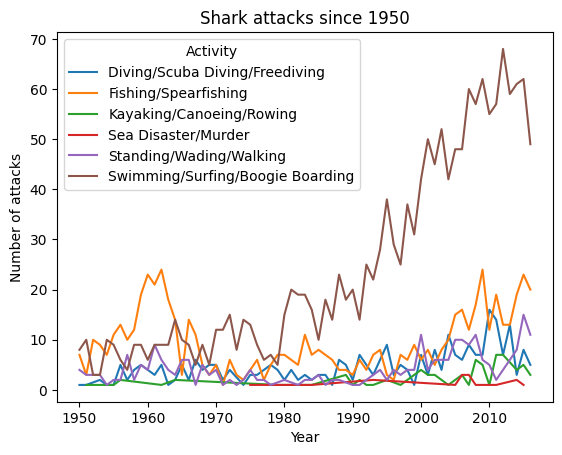

In [414]:
# Create a figure axis
fig, ax = plt.subplots(1,1)
# Plot the shark attacks by year and type of activity
sns.lineplot(data = yearly, x = 'Year', y = 'Count', hue = 'Activity', ax = ax)
# Change the axis labels
ax.set(ylabel = 'Number of attacks', title = 'Shark attacks since 1950')

In [415]:
fig.savefig(project_dir + '/Results/1.Sharks/1.Attacks_over_time_by_activity.png')

### 2. The total number of attacks per country, visualized on a world map.

This is where it gets interesting: geospatial plotting!

In [337]:
import geopandas as gpd
import pycountry

First we count the nr of attacks per country.

In [338]:
country_totals = (sharks_wide
                  .loc[sharks_wide['Year']>=1950] # Again select only 1950 or later
                  .groupby(['Country']) # Group data by grountry
                  .count() # Count the nr of observations per group (country)
                  .reset_index() # The resulting table is smaller (one observation per group instead of per record), so we reset the row indexes
                 )
country_totals = country_totals[['Country','Case']] # Keep only information of interest in the table
country_totals.rename(columns = {'Case':'Count'}, inplace = True) # Rename the counted column as "count"
print(country_totals.shape) # Inspect resulting table size: how many countries do we have?
country_totals.head() # Inspect result

(136, 2)


,Country,Count
0,ADMIRALTY ISLANDS,1
1,AMERICAN SAMOA,3
2,ANDAMAN / NICOBAR ISLANDAS,1
3,ANGOLA,1
4,ANTIGUA,1


As you can see, some "countries" in this dataset are not countries but islands/regions within countries. To plot on the world map, these could be renamed, but we're just going to throw them out for now. For the rest of the countries, we want to be able to tell Geopandas exactly which country it is. For this purpose we use so-called ISO-A3 country codes, which are standardized country codes. To get to those codes from the Country name in our table, we use the 'fuzzy search' function in Pycountry:

In [339]:
# Set up table to store results
country_totals_labeled = pd.DataFrame()
# Loop over each 'country' in our table
for i in range(country_totals.shape[0]):
    # Get that country's information:
    row = country_totals.iloc[i].copy()
    try:
        # Use the fuzzy search to match the 'country' name with a true country as included in Pycountry:
        country_estimate = pycountry.countries.search_fuzzy(row['Country'])
        # Store the resulting ISO-A3 code (here called "alpha_3") in the info row
        row['ISO_A3'] = country_estimate[0].alpha_3
        # Append the result to the results table:
        country_totals_labeled = pd.concat([country_totals_labeled, pd.DataFrame(row).T])
    except:
        None
print(country_totals_labeled.shape)
country_totals_labeled.head()

SubdivisionHierarchy(code='US-AS', country_code='US', name='American Samoa', parent_code=None, type='Outlying area')
SubdivisionHierarchy(code='NL-AW', country_code='NL', name='Aruba', parent_code=None, type='Country')
SubdivisionHierarchy(code='BZ-BZ', country_code='BZ', name='Belize', parent_code=None, type='District')
SubdivisionHierarchy(code='US-GU', country_code='US', name='Guam', parent_code=None, type='Outlying area')
SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='FR-972', country_code='FR', name='Martinique', parent='MQ', parent_code='FR-MQ', type='Overseas department')
SubdivisionHierarchy(code='FR-MQ', country_code='FR', name='Martinique', parent_code=None, type='Overseas region')
SubdivisionHierarchy(code='FR-976', country_code='FR', name='Mayotte', parent='YT', parent_code='FR-YT', type='Overseas department')
SubdivisionHierarchy(code='FR-YT', country_code='FR', name='Mayotte', parent_

,Country,Count,ISO_A3
1,AMERICAN SAMOA,3,ASM
3,ANGOLA,1,AGO
4,ANTIGUA,1,ATG
5,ARGENTINA,1,ARG
6,ARUBA,1,ABW


Download world map template: https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip
This zip file contains several files like .shp, .shx. You need all of the files to sit in the same folder on your computer, which Python can then access like so:

In [348]:
world = gpd.read_file(project_dir + "/Data/1.Sharks/world_map_data/ne_110m_admin_0_countries.shp")
world.shape
# This 'world' variable is a geopandas dataframe that contains entries for countries and some regions. Note the 'geometry' column: this contains a dense array with information describing where this country or region is in terms of the coordinates/shape of its border on the globe. This information will be used to plot the world map in our figure below.

(177, 169)

This is the real magic, we merge our 'world' representation with the country totals data we computed above. Missing countries (with presumably no shark attacks) we fill with a zero.

In [349]:
world_with_sharks = (world[['ISO_A3','geometry']] # Take only the columns that matter: ISO_A3 code of the countries on the world map + their geometry
                     .merge(country_totals_labeled[['ISO_A3','Count']], on = 'ISO_A3', how='left') # Merge with country totals of shark attacks (count)
                     .fillna(0) # Fill in missing countries with 0s
                    )
print(world_with_sharks.shape)
world_with_sharks.head()

(177, 3)


/var/folders/1_/lcw4zvln3rd_5hb93nn0kqw00000gn/T/ipykernel_47967/4053230686.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(0) # Fill in missing countries with 0s


,ISO_A3,geometry,Count
0,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",43
1,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",7
2,ESH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",0
3,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",3
4,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",1780


Text(0.5, 1.0, 'Shark attack hot spots since 1950')

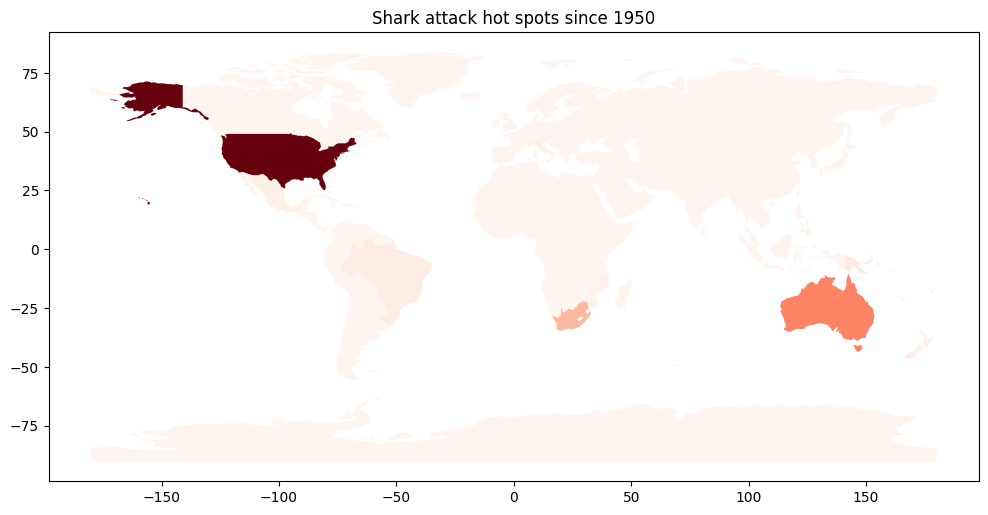

In [353]:
# Create a figure axis
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [12,6])
# Use the 'plot' method built into the geopandas dataframe
world_with_sharks.plot(column='Count', ax = ax, cmap='Reds', legend=False)
# Add a title
ax.set_title('Shark attack hot spots since 1950')

# # Experiment with removing the axes to create more of a map feel
# ax.set_axis_off()

As you can see, shark attacks are most prevalent in the United States with Australia as a close second. However, with this plotting method (and in particular the colormap) all other variation is invisible because the color map is dominated by the outlier USA. To solve this, we can create a custom categorical color map with the 'mapclassify' package and the 'scheme' keyword:

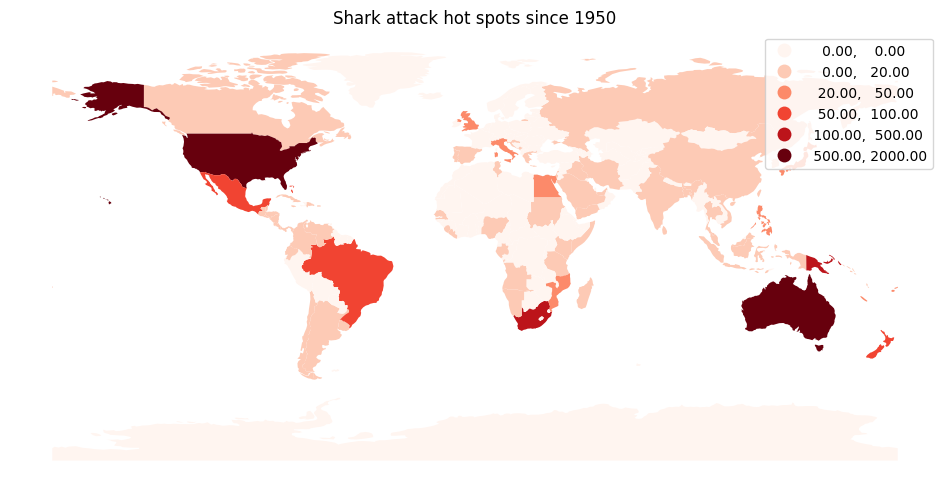

In [412]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [12,6])
world_with_sharks.fillna(0).plot(column='Count', scheme = 'UserDefined', classification_kwds = {'bins':[0,20,50,100,500,2000]},
           ax = ax, cmap='Reds', legend=True)
ax.set_title('Shark attack hot spots since 1950');
ax.set_axis_off();

In [413]:
fig.savefig(project_dir + '/Results/1.Sharks/2.Country_totals.png')

Now we can see that shark attacks are most prevalent in coastal, beachy countries. No action in landlocked countries.

### 3. The attacks located as points on a world map, colored by fatal (yes/no).

For this final analysis, we don't want country totals but precise locations. This means we can't just use the countries listed in the 'world' dataframe, but need more specific GPS coordinates (latitude and longitude). We find these using what's called "geocoding" using the Nominatim geocoder built into Geopy. This method searches the Open Street Map database, which is filled by volunteers online. In the past you used to be able to perform geocoding with the Google Maps database too, but this now costs money (you can get an API key if you want -- Google Maps still performs better).

In [357]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(timeout=10, user_agent = "blabla")

With OpenStreetMap (Nominatim), the best results are obtained from the least precise location element, i.e. the county or province. This is because some towns are not known in the database. And this level of detail is specific enough for our purposes.

In [396]:
# Let's look at an example:
example = sharks_wide.sample(1).iloc[0] # Randomly select one observation from the dataset
print(example)

Case                             2006.07.23
Date                              23-Jul-06
Year                                   2006
Country                                 USA
Location    Sargent Beach, Matagorda County
Activity               Fishing/Spearfishing
Sex                                       M
Age                                     NaN
Fatal                                     N
Name: 1231, dtype: object


In [397]:
# First we create a string with the last element of the location + the country
geocoder_query = '%s, %s'%(
    example['Location'].split(',')[-1],
    example['Country'])
# Then we run this through Nominatim geocoder:
location = geolocator.geocode(query = geocoder_query)
print(location)
print((location.latitude, location.longitude))

Matagorda County, Texas, United States
(28.8879823, -96.0035095)


Voila, we have the GPS location!

Now we want to automate this approach for all observations in the dataset. However, because this will take a long time (there are 4228 observations since 1950), we look only at the shark attacks in 2016.

In [398]:
def my_geocode(example):
    geocoder_query = '%s, %s'%(
        example['Location'].split(',')[-1],
        example['Country'])
    location = geolocator.geocode(query = geocoder_query)
    print('QUERY = %s -->\tMATCHED LOCATION = %s'%(geocoder_query, location))
    if location is not None:
        return((location.latitude, location.longitude))
    else:
        return(None)

In [407]:
my_geocode(example)

QUERY =  Matagorda County, USA -->	MATCHED LOCATION = Matagorda County, Texas, United States


(28.8879823, -96.0035095)

In [408]:
# Set up results table:
geocoded_data = pd.DataFrame()
# Select shark attacks from 2016:
data_to_explore = (sharks_wide
                   .query('Year == 2016') # Only 2016
                   .dropna(subset = 'Location') # Only observations that have a location (some are missing)
                   .copy() # Copy the dataframe so the original stays untouched
                  )
# Loop over observations by pulling out each row from the table one by one:
for i,row in data_to_explore.iterrows():
    # Geocode the row
    latlong = my_geocode(row)
    if latlong is not None:
        # If we can find the latitude and longitude, add this info to the data row
        row['lat'], row['long'] = latlong
        # Store in results table:
        geocoded_data = pd.concat([geocoded_data, pd.DataFrame(row).T])

QUERY =  Volusia County, USA -->	MATCHED LOCATION = Volusia County, Florida, United States
QUERY =  Volusia County, USA -->	MATCHED LOCATION = Volusia County, Florida, United States
QUERY =  Volusia County, USA -->	MATCHED LOCATION = Volusia County, Florida, United States
QUERY = Thirteenth Beach, AUSTRALIA -->	MATCHED LOCATION = Thirteenth Beach Road, Connewarre, City of Greater Geelong, Victoria, 3227, Australia
QUERY = Bells Beach, AUSTRALIA -->	MATCHED LOCATION = Bells Beach, Surf Coast Shire, Victoria, 3228, Australia
QUERY = Bunbury, AUSTRALIA -->	MATCHED LOCATION = Bunbury, City Of Bunbury, Western Australia, 6230, Australia
QUERY =  St. Johns County, USA -->	MATCHED LOCATION = Saint Johns County, Florida, United States
QUERY =  Oahu, USA -->	MATCHED LOCATION = Oʻahu, Honolulu County, Hawaii, United States
QUERY = Koumac, NEW CALEDONIA -->	MATCHED LOCATION = Koumac, Province Nord, Nouvelle-Calédonie, 98850, France
QUERY =  Horry County, USA -->	MATCHED LOCATION = Horry County, S

Volusia County, Florida, United States
Volusia County, Florida, United States
Volusia County, Florida, United States
Ritidian Point, Yigo Municipality, Guam, United States
St John's, Berkeley County, South Carolina, United States
San Diego County, California, United States
Volusia County, Florida, United States
Mabini, Bohol, Central Visayas, Pilipinas / Philippines
Jupiter Inlet, Jupiter Inlet Colony, Jupiter, Palm Beach County, Florida, 33477, United States
Fingal Bay, Port Stephens Council, New South Wales, 2315, Australia
Saint Lucie County, Florida, United States
Kona, Mitchell County, North Carolina, United States
Umtentweni, Hibiscus Coast Ward 12, Umtentweni, Hibiscus Coast Local Municipality, Ugu District Municipality, KwaZulu-Natal, 4235, South Africa
San Diego County, California, United States
Lee County, Texas, United States
None
None
Blue Bay, Central Coast Council, New South Wales, 2261, Australia
Broulee Post Office, 23-25, Grant Street, Broulee, Eurobodalla Shire Counci

None
South Stradbroke Island;Crab Island, South Stradbroke, Gold Coast City, Queensland, Australia
Bondi, Eastern Suburbs, Sydney, Waverley Council, New South Wales, 2026, Australia
Four Seasons O'ahu at Ko Olina, 92-1001, Olani Street, The Coconut Plantation, Kapolei, Honolulu County, Hawaii, 96707, United States
Kaikōura District, Canterbury, New Zealand / Aotearoa
Itamaracá, Groaíras, Região Geográfica Imediata de Sobral, Região Geográfica Intermediária de Sobral, Ceará, Região Nordeste, 62190-000, Brasil
None
None
The Strand, Nelson Mandela Bay Ward 1, Gqeberha, Nelson Mandela Bay Metropolitan Municipality, Eastern Cape, 6001, South Africa
Volusia County, Florida, United States
Indian River County, Florida, United States
Bonza Bay, Buffalo City Ward 4, East London, Buffalo City Metropolitan Municipality, Eastern Cape, 5200, South Africa
None
Maui, Maui County, Hawaii, United States
Byron Bay, Byron Shire Council, New South Wales, 2481, Australia
Lightning Reef PS/Holmes Rd, Holmes 

Monroe County, Illinois, United States
Saint Lucie County, Florida, United States
Fort Myers, Lee County, Florida, United States
Mangrove Cay, The Bahamas
Volusia County, Florida, United States
Olinda, Região Geográfica Imediata do Recife, Região Metropolitana do Recife, Pernambuco, Região Nordeste, Brasil
Monterey County, California, United States
Volusia County, Florida, United States
Beaufort County, North Carolina, United States
Waitpinga, City of Victor Harbor, South Australia, 5211, Australia
Four Seasons O'ahu at Ko Olina, 92-1001, Olani Street, The Coconut Plantation, Kapolei, Honolulu County, Hawaii, 96707, United States
French Frigate Shoals, Honolulu County, Hawaii, United States
Four Seasons O'ahu at Ko Olina, 92-1001, Olani Street, The Coconut Plantation, Kapolei, Honolulu County, Hawaii, 96707, United States
Lānaʻi, Maui County, Hawaii, 96763, United States
Recife, Região Geográfica Imediata do Recife, Região Metropolitana do Recife, Região Geográfica Intermediária do Rec

Saint-Pierre, La Réunion, France
San Luis Obispo County, California, United States
Orange County, California, United States
Batt Reef, Australia
Gold Beach, Curry County, Oregon, United States
South Padre Island, Cameron County, Texas, 78597, United States
Recife, Região Geográfica Imediata do Recife, Região Metropolitana do Recife, Região Geográfica Intermediária do Recife, Pernambuco, Região Nordeste, Brasil
Horry County, South Carolina, United States
Brevard County, Florida, United States
Recife, Região Geográfica Imediata do Recife, Região Metropolitana do Recife, Região Geográfica Intermediária do Recife, Pernambuco, Região Nordeste, Brasil
Orange County, California, United States
Mendocino County, California, United States
Pinellas County, Florida, United States
Byron Bay, Byron Shire Council, New South Wales, 2481, Australia
Park Rynie, uMdoni Ward 10, uMdoni Local Municipality, Ugu District Municipality, KwaZulu-Natal, 4182, South Africa
Brevard County, Florida, United States
N

Playa Tamarindo, Naranjo, Paquera, Cantón Puntarenas, Provincia Puntarenas, 60105, Costa Rica
None
None
Scarborough, Cape Town Ward 61, City of Cape Town, Western Cape, South Africa
None
Golden Beach, Caloundra, Sunshine Coast Regional, Queensland, Australia
Miami Lake, Burleigh Waters, Gold Coast City, Queensland, Australia
Recife, Região Geográfica Imediata do Recife, Região Metropolitana do Recife, Região Geográfica Intermediária do Recife, Pernambuco, Região Nordeste, Brasil
Truk Islands, Chuuk, Micronesia
Sonoma County, California, United States
Ka'anapali, Beach Path, Kaanapali, Maui County, Hawaii, 96761, United States
None
Volusia County, Florida, United States
Volusia County, Florida, United States
Tetiaroa Airport, Arue, Îles du Vent, Polynésie Française, 98701, France
Maui, Maui County, Hawaii, United States
Recife, Região Geográfica Imediata do Recife, Região Metropolitana do Recife, Região Geográfica Intermediária do Recife, Pernambuco, Região Nordeste, Brasil
Brevard Coun

None
Oʻahu, Honolulu County, Hawaii, United States
Martin County, Texas, United States
Nova Viçosa, Região Geográfica Imediata de Teixeira de Freitas, Região Geográfica Intermediária de Ilhéus-Itabuna, Bahia, Região Nordeste, Brasil
Recife, Região Geográfica Imediata do Recife, Região Metropolitana do Recife, Região Geográfica Intermediária do Recife, Pernambuco, Região Nordeste, Brasil
None
None
Pulau Pangkor, Manjung, Perak, 32300, Malaysia
None
South West Rocks, Kempsey Shire Council, New South Wales, 2431, Australia
None
Adelaide, Adelaide City Council, South Australia, Australia
San Diego, San Diego County, California, United States
None
None
Garden Island Resort, West Coast Road, Cakaudrove, Northern, Viti
Yorke Peninsula, South Australia, Australia
Bay of Fundy, New Brunswick / Nouveau-Brunswick, B0P 1R0, Canada
Great Barrier Reef, Australia
Rarotonga / Mount Smart, Maungakiekie-Tāmaki, Auckland, 1061, New Zealand / Aotearoa
Orpheus Island, Palm Island, Hinchinbrook Shire, Queen

None
Bay of Plenty, New Zealand / Aotearoa
None
Pointe au Sel, Les Quatre Robinets, Saint-Leu, Saint-Paul, La Réunion, 98230, France
None
Princess Anne, Somerset County, Maryland, 21853, United States
Volusia County, Florida, United States
Middleton Beach, City Of Albany, Western Australia, Australia
Gqeberha, Nelson Mandela Bay Metropolitan Municipality, Eastern Cape, 6006, South Africa
None
Middleton Beach, City Of Albany, Western Australia, Australia
Indian River County, Florida, United States
Volusia County, Florida, United States
Indian River County, Florida, United States
Winchester Bay, Douglas County, Oregon, United States
None
Recife, Região Geográfica Imediata do Recife, Região Metropolitana do Recife, Região Geográfica Intermediária do Recife, Pernambuco, Região Nordeste, Brasil
Palm Beach County, Florida, United States
Glengariff, Great Kei Ward 1, Great Kei Local Municipality, Amathole District Municipality, Eastern Cape, South Africa
Indian River County, Florida, United S

None
Barnstable County, Massachusetts, United States
Volusia County, Florida, United States
Maui, Maui County, Hawaii, United States
Volusia County, Florida, United States
Sarasota County, Florida, United States
Beaufort County, North Carolina, United States
Point Leo, Melbourne, Shire of Mornington Peninsula, Victoria, 3916, Australia
None
Wilderness, Garden Route District Municipality, Western Cape, 6560, South Africa
None
Volusia County, Florida, United States
Volusia County, Florida, United States
Four Seasons O'ahu at Ko Olina, 92-1001, Olani Street, The Coconut Plantation, Kapolei, Honolulu County, Hawaii, 96707, United States
Mona Vale, Sydney, Northern Beaches Council, New South Wales, 2103, Australia
Mona Vale, Sydney, Northern Beaches Council, New South Wales, 2103, Australia
Recife, Região Geográfica Imediata do Recife, Região Metropolitana do Recife, Região Geográfica Intermediária do Recife, Pernambuco, Região Nordeste, Brasil
Heron Island, Coral Sea, Heron Island, Gladsto

Recife, Região Geográfica Imediata do Recife, Região Metropolitana do Recife, Região Geográfica Intermediária do Recife, Pernambuco, Região Nordeste, Brasil
None
Palm Beach County, Florida, United States
Kailua Bay, Hillcrest, Kailua, Hawaiʻi County, Hawaii, 96840, United States
Beachview Holiday Resort, Maitland Road, Beachview, Nelson Mandela Bay Ward 40, Seaview, Nelson Mandela Bay Metropolitan Municipality, Eastern Cape, 6018, South Africa
None
Piedade, Região Imediata de Sorocaba, Região Metropolitana de Sorocaba, Região Geográfica Intermediária de Sorocaba, São Paulo, Região Sudeste, 18170-000, Brasil
None
East London, Buffalo City Metropolitan Municipality, Eastern Cape, 5201, South Africa
Albany, City Of Albany, Western Australia, 6330, Australia
Brisbane River, Sinnamon Park, Greater Brisbane, Queensland, Australia
Hibberdene, Hibiscus Coast Ward 13, Hibiscus Coast Local Municipality, Ugu District Municipality, KwaZulu-Natal, South Africa
Flagler County, Florida, United States

Recife, Região Geográfica Imediata do Recife, Região Metropolitana do Recife, Região Geográfica Intermediária do Recife, Pernambuco, Região Nordeste, Brasil
National Aquarium, 501, East Pratt Street, Inner Harbor, Baltimore, Maryland, 21202, United States
Volusia County, Florida, United States
Four Seasons O'ahu at Ko Olina, 92-1001, Olani Street, The Coconut Plantation, Kapolei, Honolulu County, Hawaii, 96707, United States
Bass Point, Shell Cove, Shellharbour City Council, New South Wales, 2529, Australia
Tillamook County, Oregon, United States
Millers Point, Millers Point Road, Cape Town Ward 61, City of Cape Town, Western Cape, 7995, South Africa
Mermaid Waters, Gold Coast City, Queensland, 4218, Australia
Scarborough, City Of Stirling, Western Australia, 6019, Australia
None
Gqeberha, Nelson Mandela Bay Metropolitan Municipality, Eastern Cape, 6006, South Africa
Nerang River, Advancetown, Gold Coast City, Queensland, Australia
Monterey County, California, United States
Palm Beach 

Richards Bay, uMhlathuze Local Municipality, King Cetswayo District Municipality, KwaZulu-Natal, 3900, South Africa
False Bay, City of Cape Town, Western Cape, South Africa
None
Adelaide, Adelaide City Council, South Australia, Australia
None
Brevard County, Florida, United States
San Mateo County, California, United States
Volusia County, Florida, United States
None
None
Winyah Bay, Georgetown County, South Carolina, United States
Sampson Cay, Exuma, The Bahamas
Monroe County, Illinois, United States
Horry County, South Carolina, United States
Saint Johns County, Florida, United States
Port Shepstone, Hibiscus Coast Local Municipality, Ugu District Municipality, KwaZulu-Natal, 4680, South Africa
None
Hawaii, United States
Vao, Malampa, Vanuatu
None
Muizenberg, City of Cape Town, Western Cape, South Africa
Palm Beach County, Florida, United States
Eerste River, Stellenbosch Local Municipality, Cape Winelands District Municipality, Western Cape, South Africa
Lizard Island, Lizard Island

None
Whale Cay, Berry Islands, The Bahamas
Palm Beach County, Florida, United States
Palm Beach County, Florida, United States
Dade County, Georgia, United States
Bonza Bay, Buffalo City Ward 4, East London, Buffalo City Metropolitan Municipality, Eastern Cape, 5200, South Africa
Palm Beach County, Florida, United States
Mpande Bay, Port St Johns Ward 1, Port St Johns Local Municipality, O.R. Tambo District Municipality, Eastern Cape, South Africa
Scottburgh, uMdoni Local Municipality, Ugu District Municipality, KwaZulu-Natal, 4180, South Africa
Nahoon Valley Park, Buffalo City Ward 29, East London, Buffalo City Metropolitan Municipality, Eastern Cape, 5210, South Africa
Palm Beach County, Florida, United States
Lifou, Province des îles Loyauté, Nouvelle-Calédonie, 98820, France
Mtunzini, uMlalazi Local Municipality, King Cetswayo District Municipality, KwaZulu-Natal, 3867, South Africa
None
Amanzimtoti, eThekwini Ward 93, KwaMakhutha, eThekwini Metropolitan Municipality, KwaZulu-Natal

Macassar, Cape Town Ward 109, City of Cape Town, Western Cape, 7134, South Africa
Algoa Bay, Sarah Baartman District Municipality, Eastern Cape, South Africa
Byron Bay, Byron Shire Council, New South Wales, 2481, Australia
大鹏湾 - 大鵬灣 Mirs Bay, 广东省, 香港 Hong Kong, 中国
Volusia County, Florida, United States
None
Okaloosa County, Florida, United States
False Bay, City of Cape Town, Western Cape, South Africa
None
None
Balade, Pouébo, Province Nord, Nouvelle-Calédonie, 98824, France
Palm Beach County, Florida, United States
Palm Beach County, Florida, United States
Palm Beach County, Florida, United States
County (Quincy) Maintenance Station, East Quincy, Plumas County, California, 95971, United States
Seal Island, Western Cape, 7220, South Africa
None
Port Alfred, Ndlambe Local Municipality, Sarah Baartman District Municipality, Eastern Cape, 6170, South Africa
Hawaii, United States
Bribie Island, Greater Brisbane, City of Moreton Bay, Queensland, 4507, Australia
Sodwana, P748, uMhlabuyaling

San Mateo County, California, United States
None
Myers Creek, Hattiesburg, Forrest County, Mississippi, United States
Omiš, Grad Omiš, 21310, Hrvatska
San Mateo County, California, United States
Mendocino County, California, United States
Chatham County, North Carolina, United States
Gulf of Mexico Brook, Town of Hardenburgh, Ulster County, New York, United States
Volusia County, Florida, United States
Marin County, California, United States
Arniston, Cape Agulhas Local Municipality, Overberg District Municipality, Western Cape, South Africa
Glengariff, Great Kei Ward 1, Great Kei Local Municipality, Amathole District Municipality, Eastern Cape, South Africa
Miami-Dade County, Florida, United States
Amanzimtoti, eThekwini Ward 93, KwaMakhutha, eThekwini Metropolitan Municipality, KwaZulu-Natal, 4125, South Africa
Amanzimtoti, eThekwini Ward 93, KwaMakhutha, eThekwini Metropolitan Municipality, KwaZulu-Natal, 4125, South Africa
Macassar, Cape Town Ward 109, City of Cape Town, Western Ca

Durban, eThekwini Metropolitan Municipality, KwaZulu-Natal, 4057, South Africa
Ramsgate, Hibiscus Coast Local Municipality, Ugu District Municipality, KwaZulu-Natal, South Africa
Hillsborough County, Florida, United States
Palm Beach County, Florida, United States
Propeller of HMNZS Otago (F111), 18, Clearwater Cove, Hobsonville, Upper Harbour, Auckland, 0618, New Zealand / Aotearoa
None
Okaloosa County, Florida, United States
Tahiti, Îles du Vent, Polynésie Française, France
Pulau Aur, Mersing, Johor, Malaysia
Taganga, Santa Marta, Magdalena, RAP Caribe, Colombia
Sonoma County, California, United States
Florida Keys, Monroe County, Florida, United States
Charleston County, South Carolina, United States
None
Spanish Wells, The Bahamas
Pinellas County, Florida, United States
Broward County, Florida, United States
Palm Beach County, Florida, United States
South Coast, Queensland, Australia
None
Stockton Bight, New South Wales, Australia
Richards Bay, uMhlathuze Local Municipality, King C

None
None
Umkomaas, eThekwini Metropolitan Municipality, KwaZulu-Natal, 4170, South Africa
Okaloosa County, Florida, United States
None
臺北市, 臺灣
None
Broward County, Florida, United States
Acapulco, Acapulco de Juárez, Guerrero, 39300, México
None
Bay County, Florida, United States
Palm Beach County, Florida, United States
西大寺, 五反田地下道, 西大寺北, 東区, 岡山市, 岡山県, 704-8116, 日本
None
Island Rock, KwaZulu-Natal, South Africa
None
Island Rock, KwaZulu-Natal, South Africa
Palm Beach County, Florida, United States
None
None
None
Long Island, New York, United States
Los Angeles County, California, United States
None
Totoya Island, Tovu, Lau, Eastern, Viti
Port Edward, Hibiscus Coast Local Municipality, Ugu District Municipality, KwaZulu-Natal, 4295, South Africa
Naviti Island, Malevu, Ba, Western, Viti
None
None
None
None
Broward County, Florida, United States
Dakar, Région de Dakar, Sénégal
None
None
None
Wellington, Wellington City, Wellington, 6011, New Zealand / Aotearoa
Muizenberg, City of Cape To

None
Noosa Heads, Noosa Shire, Queensland, 4567, Australia
None
None
Manila Bay, Cavite, Calabarzon, Pilipinas / Philippines
Palm Beach County, Florida, United States
Lelepa, Natapao, Shefa, Vanuatu
Palm Beach County, Florida, United States
Monroe County, Illinois, United States
None
None
None
Chioggia, Venezia, Veneto, 30015, Italia
Broome, Shire Of Broome, Western Australia, 6752, Australia
Sonoma County, California, United States
Georgetown County, South Carolina, United States
None
Four Seasons O'ahu at Ko Olina, 92-1001, Olani Street, The Coconut Plantation, Kapolei, Honolulu County, Hawaii, 96707, United States
None
None
None
Cape Moreton, Moreton Island, Brisbane City, Queensland, 4025, Australia
Riccione, Rimini, Emilia-Romagna, Italia
None
Miami, Miami-Dade County, Florida, United States
Martin County, Texas, United States
Saint Johns County, Florida, United States
Rabaul, East New Britain, Islands Region, Papua Niugini
Manus, Islands Region, Papua Niugini
Marin County, Califo

Acapulco, Acapulco de Juárez, Guerrero, 39300, México
Ilha de São Miguel, Açores, Portugal
檜山振興局, 北海道, 日本
Cabuli Island, El Nido, Palawan, Mimaropa, Pilipinas / Philippines
Bay County, Florida, United States
Bay County, Florida, United States
Charleston, Charleston County, South Carolina, United States
None
San Diego County, California, United States
Grad Pula, Istarska županija, Hrvatska
CITY! WAKAYAMA, 和歌山市, 和歌山県, 640-8511, 日本
Chatham County, North Carolina, United States
Los Angeles County, California, United States
Isola del Giglio, Grosseto, Toscana, 58012, Italia
San Diego County, California, United States
San Diego County, California, United States
牛窓町牛窓, 瀬戸内市, 岡山県, 701-4302, 日本
San Diego County, California, United States
San Diego County, California, United States
Los Angeles County, California, United States
None
Palm Beach County, Florida, United States
None
None
None
Isla San Pedro Nolasco, Guaymas, Sonora, México
San Diego County, California, United States
Marin County, Cal

None
North Bondi, Eastern Suburbs, Sydney, Waverley Council, New South Wales, 2026, Australia
None
None
Περιφερειακή Ενότητα Κέρκυρας, Περιφέρεια Ιονίων Νήσων, Αποκεντρωμένη Διοίκηση Πελοποννήσου, Δυτικής Ελλάδας και Ιονίου, Ελλάς
Princess Anne, Somerset County, Maryland, 21853, United States
Princess Anne, Somerset County, Maryland, 21853, United States
Renard Islands, Milne Bay, Southern Region, Papua Niugini
Hus Island, Ahus, Manus District, Manus, Islands Region, Papua Niugini
Enuk Islands, Nusailas, New Ireland, Islands Region, Papua Niugini
None
None
Manus, Islands Region, Papua Niugini
Young Australia Road, Woowoonga, North Burnett Regional, Queensland, Australia
None
None
None
Los Angeles County, California, United States
Los Angeles County, California, United States
None
Los Angeles County, California, United States
Grad Opatija, Primorsko-goranska županija, Hrvatska
Pago Pago Harbor, Leloaloa, Maʻopūtasi County, Eastern District, American Samoa, 96799, United States
Windy Hil

Port St Johns, Port St Johns Local Municipality, O.R. Tambo District Municipality, Eastern Cape, South Africa
None
Bondi Beach, Eastern Suburbs, Sydney, Waverley Council, New South Wales, 2026, Australia
Durban, eThekwini Metropolitan Municipality, KwaZulu-Natal, 4057, South Africa
Hawkesbury River, Cowan, Gosford, Central Coast Council, New South Wales, 2083, Australia
None
Kirra, Coolangatta, Gold Coast City, Queensland, 4225, Australia
Jervis Bay, Jervis Bay Territory, Australia
Brisbane City, Queensland, Australia
Amatjatpalk, West Arnhem, West Arnhem Region, Northern Territory, Australia
Brisbane City, Queensland, Australia
Yeppoon, Livingstone Shire, Queensland, Australia
San Diego County, California, United States
Sarina, Mackay Regional, Queensland, Australia
None
None
The District Council of Streaky Bay, South Australia, Australia
None
Albenga, Savona, Liguria, Italia
Econo Lodge Inn & Suites Port Arthur near Sabine Pass, Highway 73, Pear Ridge, Port Arthur, Jefferson County, 

In [409]:
print(geocoded_data.shape)
geocoded_data.head()

(86, 11)


,Case,Date,Year,Country,Location,Activity,Sex,Age,Fatal,lat,long
0,2016.09.18.c,18-Sep-16,2016,USA,"New Smyrna Beach, Volusia County",Swimming/Surfing/Boogie Boarding,M,16,N,29.053341,-81.131076
1,2016.09.18.b,18-Sep-16,2016,USA,"New Smyrna Beach, Volusia County",Swimming/Surfing/Boogie Boarding,M,36,N,29.053341,-81.131076
2,2016.09.18.a,18-Sep-16,2016,USA,"New Smyrna Beach, Volusia County",Swimming/Surfing/Boogie Boarding,M,43,N,29.053341,-81.131076
3,2016.09.17,17-Sep-16,2016,AUSTRALIA,Thirteenth Beach,Swimming/Surfing/Boogie Boarding,M,NaN,N,-38.283703,144.452598
4,2016.09.15,16-Sep-16,2016,AUSTRALIA,Bells Beach,Swimming/Surfing/Boogie Boarding,M,NaN,N,-38.376708,144.251951


Looks like we have 86 shark attacks with precise GPS location. Now we want to draw these points on the map. We already loaded the world map before (variabel 'world').

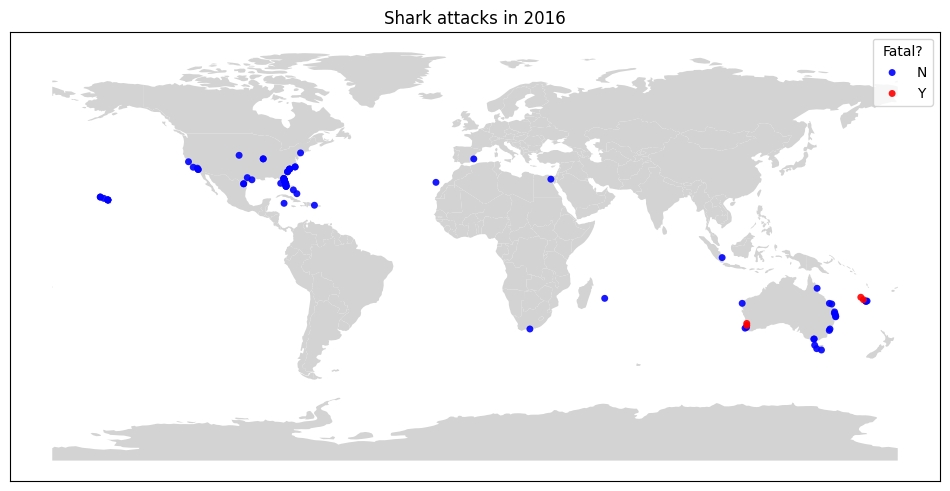

In [410]:
# Create a GeoDataFrame from the points data
points_gdf = gpd.GeoDataFrame(
    geocoded_data, geometry=gpd.points_from_xy(geocoded_data['long'], geocoded_data['lat'])
)

# Plot world map
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [12,6])
world.plot(ax = ax, color='lightgray')

# Plot points on the map
# First set the color map. We want to separately plot the nonfatal and fatal attacks, as blue and red, respectively:
c_map = {'Y':'red','N':'blue', 'U':'blue'}
# Then we loop over the nonfatal and fatal groups of attacks:
for fatal in ['N','Y']:
    # Select the nonfatal/fatal points:
    plot_dat = points_gdf.loc[points_gdf['Fatal']==fatal,]
    # Plot these points:
    ax.scatter(plot_dat.long, plot_dat.lat, c=plot_dat.Fatal.map(c_map), s=25, label=fatal,
               alpha=0.9, edgecolors='none')

# Set title and legend title:
ax.set(title = 'Shark attacks in 2016', xticks = [], yticks = [])
ax.legend(title = 'Fatal?')

In [411]:
fig.savefig(project_dir + '/Results/1.Sharks/3.Attacks_on_map.png')